### Walkthrough for deforestation methodology

In [1]:
import os
import numpy as np
import pandas as pd
from io import StringIO, BytesIO
import xarray as xr
from google.cloud import storage
from onnxruntime import InferenceSession
import copy
import cv2 as cv
from skimage.morphology import remove_small_objects
import datetime

In [2]:
crop_size = 250

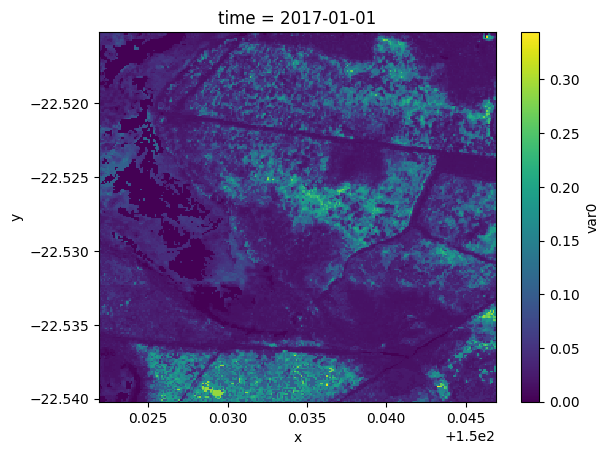

In [3]:
s2wcf = xr.open_dataset('/home/muye/function-registry-dev/functions/s2wcf.nc')
s2wcf = s2wcf.isel(x = slice(crop_size), y = slice(crop_size)).var0
s2wcf = s2wcf.fillna(0.0) 
s2wcf.isel(time = 0).plot.imshow()


In [4]:
# reference 1: Landsat wcf (all 7 years available for forest and defor metrics)
lswcf = xr.open_dataset('/home/muye/function-registry-dev/functions/lswcf.nc')
lswcf = lswcf.isel(x = slice(crop_size), y = slice(crop_size)).var0
lswcf = lswcf.fillna(0.0)
print(lswcf.dims)

# reference 2: slats wcf 
# only available for 2021 => forest mapping metrics
slfpc = xr.open_dataset('/home/muye/function-registry-dev/functions/slfpc.nc')
slfpc = slfpc.isel(x = slice(crop_size), y = slice(crop_size)).var0
slfpc = slfpc.fillna(0.0)
print(slfpc.dims)


('time', 'y', 'x')
('time', 'y', 'x')


In [5]:
# Additional data required
ndvi = xr.open_dataset('/home/muye/function-registry-dev/functions/ndvi.nc')
ndvi = ndvi.isel(x = slice(crop_size), y = slice(crop_size)).var0
print(ndvi.dims)

ndvimin = ndvi.min(dim='time')
ndvimax = ndvi.max(dim='time')
mask = (ndvimin > 0.1) * ( (ndvimax-ndvimin) < 0.5 )

meta = xr.open_dataset('/home/muye/function-registry-dev/functions/meta.nc')
meta = meta.isel(x = slice(crop_size), y = slice(crop_size)).var0

zhao = xr.open_dataset('/home/muye/function-registry-dev/functions/zhao.nc')
zhao = zhao.isel(x = slice(crop_size), y = slice(crop_size)).var0


forest_definitions = {
    'FAO': {
        'min_crown_cover': 0.1,   # minimum crown cover (as fraction)
        'min_cover_area': 0.5,    # minimum area (in ha)
        'min_height': 5           # minimum height (in m)
    },
    'Australian': {
        'min_crown_cover': 0.2,
        'min_cover_area': 0.2,
        'min_height': 2
    }
}

au_kernel_csv = """0,0,0,0.000527,0,0,0
0,0.0076873,0.039743,0.0498,0.039743,0.0076873,0
0,0.039743,0.05,0.05,0.05,0.039743,0
0.000527,0.0498,0.05,0.05,0.05,0.0498,0.000527
0,0.039743,0.05,0.05,0.05,0.039743,0
0,0.0076873,0.039743,0.0498,0.039743,0.0076873,0
0,0,0,0.000527,0,0,0"""

kernel_au = np.genfromtxt(StringIO(au_kernel_csv), delimiter=',').astype(np.float32)

fao_kernel_csv = """0,0,0.00085576,0.0070101,0.0095791,0.0070101,0.00085576,0,0
0,0.0039758,0.017857,0.02,0.02,0.02,0.017857,0.0039758,0
0.00085576,0.017857,0.02,0.02,0.02,0.02,0.02,0.017857,0.00085576
0.0070101,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0070101
0.0095791,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0095791
0.0070101,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0070101
0.00085576,0.017857,0.02,0.02,0.02,0.02,0.02,0.017857,0.00085576
0,0.0039758,0.017857,0.02,0.02,0.02,0.017857,0.0039758,0
0,0,0.00085576,0.0070101,0.0095791,0.0070101,0.00085576,0,0"""

kernel_fao = np.genfromtxt(StringIO(fao_kernel_csv), delimiter=',').astype(np.float32)

forest_definitions['FAO']['kernel'] = kernel_fao
forest_definitions['Australian']['kernel'] = kernel_au

('time', 'y', 'x')


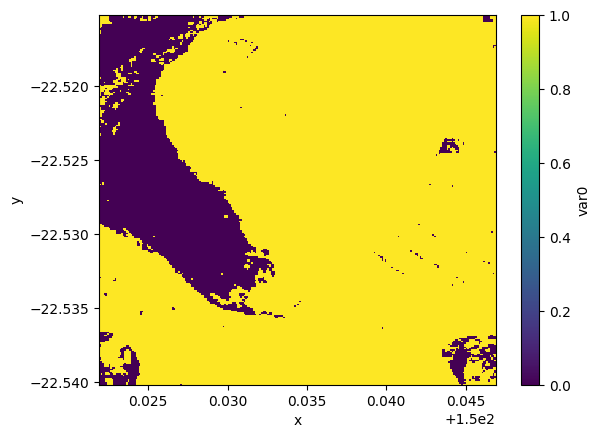

In [6]:
mask.plot.imshow()

---

#### 1. Crown cover mapping

In [7]:
thresh = 0.04
definition = 'Australian'

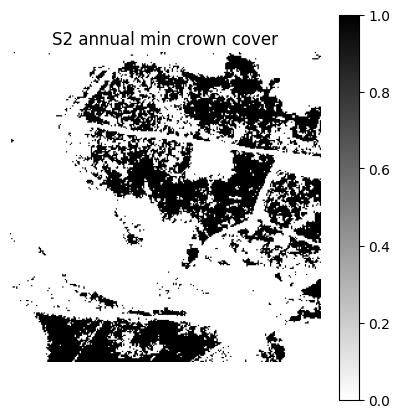

In [8]:
s2wcf_ref = s2wcf.sel(time=s2wcf.time.dt.year.isin([2017, 2018, 2019, 2020]))

s2mean_ref = s2wcf_ref.mean('time').values      
s2std_ref = s2wcf_ref.std('time').values 

s2trees_ref = (s2wcf_ref > thresh).mean('time').values >= 0.5   
s2trees_ref = np.where(mask.values, s2trees_ref, 0.0)     


import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(s2trees_ref, cmap='binary')
plt.colorbar()
plt.title('S2 annual min crown cover')
plt.axis('off')
plt.show()


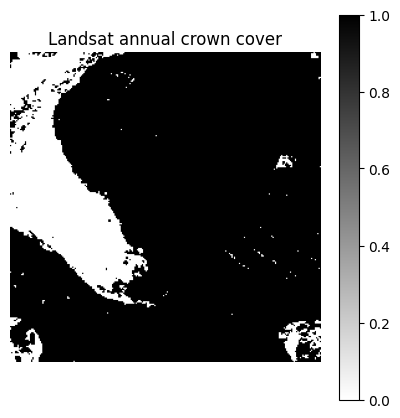

In [9]:
lswcf_ref = lswcf.sel(time=lswcf.time.dt.year.isin([2017, 2018, 2019, 2020]))
lsmean_ref = lswcf_ref.mean('time').values
lsstd_ref = lswcf_ref.std('time').values

lstrees_ref = (lswcf_ref > thresh).mean('time').values >= 0.5
lstrees_ref = np.where(mask.values, lstrees_ref, 0.0)


plt.figure(figsize=(5,5))
plt.imshow(lstrees_ref, cmap='binary')
plt.colorbar()
plt.title('Landsat annual crown cover')
plt.axis('off')
plt.show()

---

#### 2. Forest mappings

In [10]:
s2eachyear_forest = []
lseachyear_forest = []
s2defors = []; lsdefors = []

input_years = [2023, 2022, 2021]

def map_forest(trees, min_crown_cover, min_cover_area, kernel, debug=False, **kwargs):
    x = cv.filter2D(trees.astype(np.float32), -1, kernel, borderType=cv.BORDER_CONSTANT) > min_crown_cover
    x = cv.filter2D(x.astype(np.float32), -1, kernel, borderType=cv.BORDER_CONSTANT) > (1 - min_crown_cover)
    x = remove_small_objects(x, min_size=int(100 * min_cover_area))  #trim forest
    x = remove_small_objects(~x, min_size=int(100 * min_cover_area))  # trim non-forest

    return ~x

for yr in input_years:
    # 2023, 2022, 2021
    #s2wcf_now = s2wcf.sel(time=lswcf.time.dt.year.isin([yr])).values    
    s2wcf_now = s2wcf.sel(time=str(yr)).values.squeeze()     
    s2z = (s2wcf_now - s2mean_ref) / s2std_ref            # calculate Z-score

    #lswcf_now = lswcf.sel(time=lswcf.time.dt.year.isin([yr])).values
    lswcf_now = lswcf.sel(time=str(yr)).values.squeeze()
    lsz = (lswcf_now - lsmean_ref) / lsstd_ref

    # Step 4: Crown cover mapping
    s2trees_gone = (((s2z < -3) & (s2mean_ref > thresh) & (s2wcf_now < (thresh*0.75))) | (s2wcf_now < (thresh*0.5)))
    lstrees_gone = (((lsz < -3) & (lsmean_ref > thresh) & (lswcf_now < (thresh*0.75))) | (lswcf_now < (thresh*0.5)))

    s2trees_now = s2trees_ref.copy()
    s2trees_now[s2trees_gone] = 0                     # Remove trees where TreeGone criterion is met.
    lstrees_now = lstrees_ref.copy()
    lstrees_now[lstrees_gone] = 0

    # Step 5: Forest mapping
    s2forest_ref = map_forest(s2trees_ref, **forest_definitions[definition])
    s2forest_now = map_forest(s2trees_now, **forest_definitions[definition])

    lsforest_ref = map_forest(lstrees_ref, **forest_definitions[definition])
    lsforest_now = map_forest(lstrees_now, **forest_definitions[definition])

    forest_def_height = copy.deepcopy(forest_definitions)   # deepcopy required to copy all layers of keys
    forest_def_height['FAO']['min_crown_cover'] = 0
    forest_def_height['Australian']['min_crown_cover'] = 0

    # meta and zhao get updated in loop: create a copy to reserve the original version from input
    meta_theight_temp = meta.copy()
    meta_theight_temp = meta_theight_temp.fillna(0).isel(time = 0).values
    zhao_theight_temp = zhao.copy()
    zhao_theight_temp = zhao_theight_temp.isel(time = 0).values

    meta_forest = map_forest(meta_theight_temp>forest_def_height[definition]['min_height'], debug=True, **forest_def_height[definition])  # (1,256,256)
    zhao_forest = map_forest(zhao_theight_temp>forest_def_height[definition]['min_height'], **forest_def_height[definition])
    forest_h = (meta_forest + zhao_forest) > 0     #choose the larger of meta and zhao

    s2forest_ref[forest_h == 0] = 0  #mask ref_forest (to 0) where treeH is 0
    s2forest_now[forest_h == 0] = 0

    lsforest_ref[forest_h == 0] = 0
    lsforest_now[forest_h == 0] = 0

    s2eachyear_forest.append(s2forest_now)
    lseachyear_forest.append(lsforest_now)

    s2defor = s2forest_ref.astype(np.float32)
    s2defor[(s2forest_ref == 1) & (s2forest_now == 0)] = 2
    s2defors.append(s2defor)

    lsdefor = lsforest_ref.astype(np.float32)
    lsdefor[(lsforest_ref == 1) & (lsforest_now == 0)] = 2
    lsdefors.append(lsdefor)
    

forest ref: [0. 1.]
forest now: [0. 1.]
before: [0. 1.]
after: [0. 1. 2.]
forest ref: [0. 1.]
forest now: [0. 1.]
before: [0. 1.]
after: [0. 1. 2.]
forest ref: [0. 1.]
forest now: [0. 1.]
before: [0. 1.]
after: [0. 1. 2.]


/tmp/ipykernel_19092/855466868.py:19: RuntimeWarning: divide by zero encountered in divide
  s2z = (s2wcf_now - s2mean_ref) / s2std_ref            # calculate Z-score
/tmp/ipykernel_19092/855466868.py:19: RuntimeWarning: invalid value encountered in divide
  s2z = (s2wcf_now - s2mean_ref) / s2std_ref            # calculate Z-score
/tmp/ipykernel_19092/855466868.py:23: RuntimeWarning: divide by zero encountered in divide
  lsz = (lswcf_now - lsmean_ref) / lsstd_ref
/tmp/ipykernel_19092/855466868.py:23: RuntimeWarning: invalid value encountered in divide
  lsz = (lswcf_now - lsmean_ref) / lsstd_ref


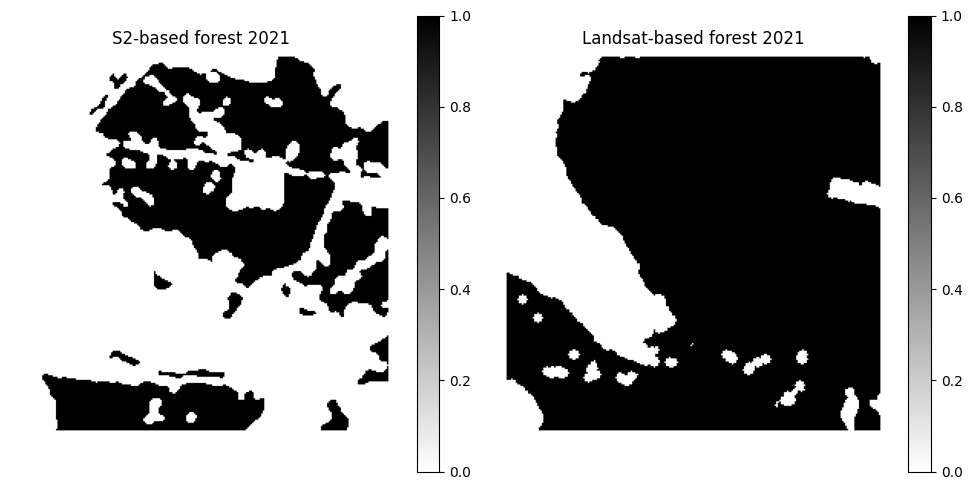

In [11]:
# Compare 2021 forests
s2_21 = s2eachyear_forest[2]; ls_21 = lseachyear_forest[2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))  

ax1.imshow(s2_21, cmap='binary')
ax1.set_title('S2-based forest 2021')
fig.colorbar(ax1.images[0], ax=ax1)
ax1.axis('off')


ax2.imshow(ls_21, cmap='binary') 
ax2.set_title('Landsat-based forest 2021')  
fig.colorbar(ax2.images[0], ax=ax2)
ax2.axis('off')

plt.tight_layout()  
plt.show()

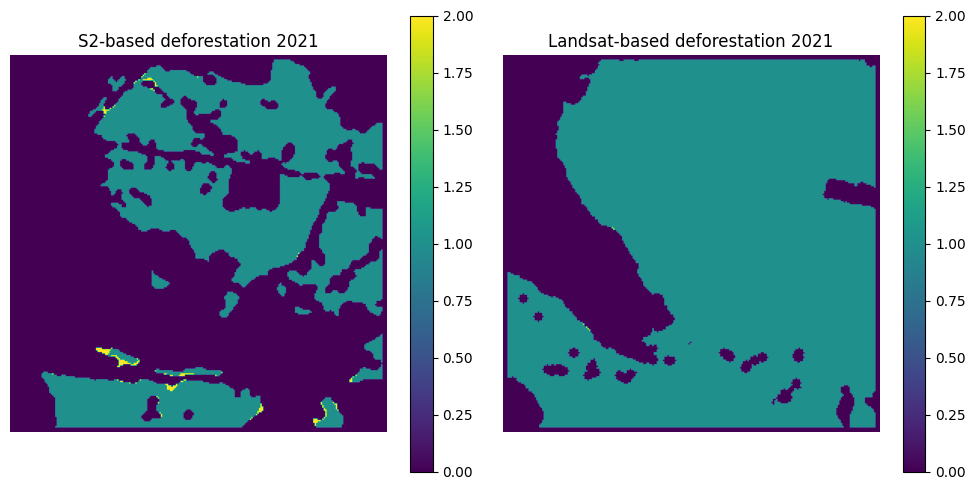

In [12]:
# Compare 2021 forests

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))  

ax1.imshow(s2defors[2], cmap='viridis')
ax1.set_title('S2-based deforestation 2021')
fig.colorbar(ax1.images[0], ax=ax1)
ax1.axis('off')


ax2.imshow(lsdefors[2], cmap='viridis') 
ax2.set_title('Landsat-based deforestation 2021')  
fig.colorbar(ax2.images[0], ax=ax2)
ax2.axis('off')

plt.tight_layout()  
plt.show()


---

#### 3. Deforestation for 2023

In [13]:
s2D23, s2D22, s2D21 = s2defors

# first reassign 2023 defor:
s2D23[s2D23==0] = 255  # no forest
s2D23[s2D23==1] = 0    # forest
s2D23[s2D23==2] = 3    # 2023 defor

# update colour if 23 defor carried fwd to 22:
s2D23[(s2D23 == 3) & (s2D22 == 2)] = 2

# update colour if 23 defor carried fwd to 22 then 21:
# s2D23==2 are those deforested in both 23 & 22
s2D23[(s2D23 == 2) & (s2D21 == 2)] = 1

np.unique(s2D23)

array([  0.,   1.,   2.,   3., 255.], dtype=float32)

In [14]:
lsD23, lsD22, lsD21 = lsdefors

# first reassign 2023 defor:
lsD23[lsD23==0] = 255  # no forest
lsD23[lsD23==1] = 0    # forest
lsD23[lsD23==2] = 3    # 2023 defor

# update colour if 23 defor carried fwd to 22:
lsD23[(lsD23 == 3) & (lsD22 == 2)] = 2

# update colour if 23 defor carried fwd to 22 then 21:
# lsD23==2 are those deforested in both 23 & 22
lsD23[(lsD23 == 2) & (lsD21 == 2)] = 1

np.unique(lsD23)

array([  0.,   1.,   2.,   3., 255.], dtype=float32)

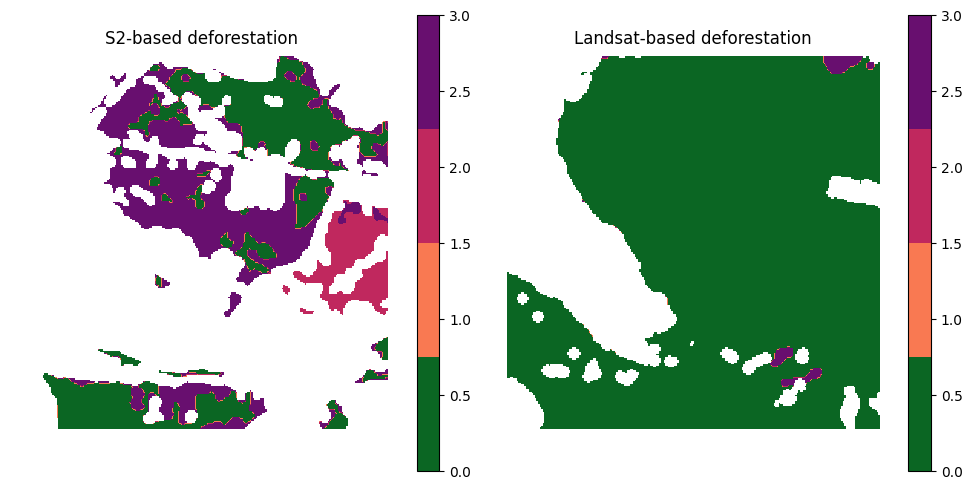

In [15]:
# Compare overall deforestations
from matplotlib.colors import ListedColormap

# Create custom colormap
colors = ["#0B6623", "#F97952", "#C0285E", "#680F6F"]
cmap = ListedColormap(colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# First plot
im1 = ax1.imshow(np.ma.masked_where(s2D23 == 255, s2D23), cmap=cmap)
ax1.set_title('S2-based deforestation')
fig.colorbar(im1, ax=ax1)
ax1.axis('off')

# Second plot
im2 = ax2.imshow(np.ma.masked_where(lsD23 == 255, lsD23), cmap=cmap)
ax2.set_title('Landsat-based deforestation')
fig.colorbar(im2, ax=ax2)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
jupyter nbconvert /home/muye/function-registry-dev/functions/defor_eval.ipynb --to html